# 1. Importing Libraries

In [65]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import os
import pymysql
import seaborn as sns
import sys
from scipy import stats

# path = os.path.abspath("etl")
sys.path.append('/Users/jiajunseah/property-price/is3107-property-price-analysis/etl')

#import helper functions
from RetrieveDB import RetrieveDB

# 2. Connect to MySQL

In [66]:
db = RetrieveDB(db_connect_type="LOCAL")

Exception during reset or similar
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pymysql/connections.py", line 803, in _write_bytes
    self._sock.sendall(data)
BrokenPipeError: [Errno 32] Broken pipe

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sqlalchemy/pool/base.py", line 763, in _finalize_fairy
    fairy._reset(pool, transaction_was_reset)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sqlalchemy/pool/base.py", line 1038, in _reset
    pool._dialect.do_rollback(self)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sqlalchemy/engine/default.py", line 683, in do_rollback
    dbapi_connection.rollback()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-pac

Connection to the 127.0.0.1 for user root created successfully with <sqlalchemy.engine.base.Connection object at 0x17ff3bad0>.


# 3. Load dataset from SQL queries

In [67]:
data = db.get_merged_transactions()
data = pd.DataFrame(data)

In [68]:
amenities = db.get_amenities()
amenities = pd.DataFrame(amenities)

In [69]:
amenities["amenity_type"].value_counts()

amenity_type
Carpark         804
Supermarket     524
Kindergarten    398
Park            316
Pharmacy        269
Gym             159
Hawker          125
MRT             119
LRT              38
Name: count, dtype: int64

In [70]:
districts = db.get_districts()
districts = pd.DataFrame(districts)

# 4. Data Cleaning

## Irrelevant and Errorneous Columns

Index columns and name columns which are not meaningful have been pre-emptively excluded from the SQL query. This showcases one of the benefits of having a robust ETL pipeline whereby downstream applications can customize the data to be retrieved according to business needs.

In [71]:
#inspect resultant dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251895 entries, 0 to 251894
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   district_id        251895 non-null  int64  
 1   long               251895 non-null  float64
 2   lat                251895 non-null  float64
 3   transaction_year   251895 non-null  int64  
 4   transaction_month  251895 non-null  int64  
 5   type_of_sale       251895 non-null  object 
 6   price              251895 non-null  float64
 7   property_type      251895 non-null  object 
 8   lease_year         217672 non-null  float64
 9   lease_duration     217672 non-null  float64
 10  floor_range_start  239161 non-null  float64
 11  floor_range_end    239161 non-null  float64
 12  floor_area         251895 non-null  float64
dtypes: float64(8), int64(3), object(2)
memory usage: 25.0+ MB


## Handle Missing values

In [72]:
na_count = data.isna().sum().sort_values(ascending=False)
na_count

lease_year           34223
lease_duration       34223
floor_range_start    12734
floor_range_end      12734
district_id              0
long                     0
lat                      0
transaction_year         0
transaction_month        0
type_of_sale             0
price                    0
property_type            0
floor_area               0
dtype: int64

In [73]:
#lease_duration that is null refers to freehold, impute with value 'freehold' and convert existing values (99, 999 to string)
data['lease_duration'].fillna('freehold', inplace=True)

In [74]:
#lease_year is Missing At Random (MAR), related to another observed variable: lease_duration, bc. freehold has no lease
#impute with modal lease_year value
modal_lease_year = data['lease_year'].mode()
data['lease_year'].fillna(modal_lease_year[0], inplace=True)

In [75]:
#floor range start and end highly dependent on project_name and property_type
#assume that similar property type under same project will have approx. same number of levels
#use mean of properties grouped by project_name and property_type to impute missing values
mean_of_floor_start_by_property_grps = data.groupby(['property_type'])['floor_range_start'].mean()
#inspect mean values and see that detached, semi-detached and terrace still have missing values
#impute detached with strata detached, semi detached with strata semi detached and terrace with strata terrace
mean_of_floor_start_by_property_grps['Detached'] = mean_of_floor_start_by_property_grps['Strata Detached']
mean_of_floor_start_by_property_grps['Semi-detached'] = mean_of_floor_start_by_property_grps['Strata Semi-detached']
mean_of_floor_start_by_property_grps['Terrace'] = mean_of_floor_start_by_property_grps['Strata Terrace']

#round off floor ranges to nearest integers
mean_of_floor_start_by_property_grps = mean_of_floor_start_by_property_grps.apply(lambda x: round(x))

#verify that all property types have non null mean values
print(mean_of_floor_start_by_property_grps)

property_type
1 ROOM                   6
2 ROOM                   8
3 ROOM                   7
4 ROOM                   8
5 ROOM                   8
Apartment                9
Condominium              7
Detached                 1
EXECUTIVE                6
Executive Condominium    6
MULTI-GENERATION         6
Semi-detached            1
Strata Detached          1
Strata Semi-detached     1
Strata Terrace           1
Terrace                  1
Name: floor_range_start, dtype: int64


In [76]:
#repeat above step for floor range end
#use mean of properties grouped by project_name and property_type to impute missing values
mean_of_floor_end_by_property_grps = data.groupby(['property_type'])['floor_range_end'].mean()
#inspect mean values and see that detached, semi-detached and terrace still have missing values
#impute detached with strata detached, semi detached with strata semi detached and terrace with strata terrace
mean_of_floor_end_by_property_grps['Detached'] = mean_of_floor_end_by_property_grps['Strata Detached']
mean_of_floor_end_by_property_grps['Semi-detached'] = mean_of_floor_end_by_property_grps['Strata Semi-detached']
mean_of_floor_end_by_property_grps['Terrace'] = mean_of_floor_end_by_property_grps['Strata Terrace']

#round off floor ranges to nearest integers
mean_of_floor_end_by_property_grps = mean_of_floor_end_by_property_grps.apply(lambda x: round(x))

#verify that all property types have non null mean values
print(mean_of_floor_end_by_property_grps)

property_type
1 ROOM                    8
2 ROOM                   10
3 ROOM                    9
4 ROOM                   10
5 ROOM                   10
Apartment                13
Condominium              11
Detached                  5
EXECUTIVE                 8
Executive Condominium    10
MULTI-GENERATION          8
Semi-detached             5
Strata Detached           5
Strata Semi-detached      5
Strata Terrace            5
Terrace                   5
Name: floor_range_end, dtype: int64


In [77]:
#assign missing floor range start and floor range end
floor_start_mapping = dict(mean_of_floor_start_by_property_grps)
floor_end_mapping = dict(mean_of_floor_end_by_property_grps)
data['floor_range_start'].fillna(data['property_type'].map(floor_start_mapping), inplace=True)
data['floor_range_end'].fillna(data['property_type'].map(floor_end_mapping), inplace=True)

In [78]:
#check that na values have been handled
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251895 entries, 0 to 251894
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   district_id        251895 non-null  int64  
 1   long               251895 non-null  float64
 2   lat                251895 non-null  float64
 3   transaction_year   251895 non-null  int64  
 4   transaction_month  251895 non-null  int64  
 5   type_of_sale       251895 non-null  object 
 6   price              251895 non-null  float64
 7   property_type      251895 non-null  object 
 8   lease_year         251895 non-null  float64
 9   lease_duration     251895 non-null  object 
 10  floor_range_start  251895 non-null  float64
 11  floor_range_end    251895 non-null  float64
 12  floor_area         251895 non-null  float64
dtypes: float64(7), int64(3), object(3)
memory usage: 25.0+ MB


In [79]:
#force appropriate columns to be int
data = data.astype({'lease_year': int, 'floor_range_start': int, 'floor_range_end': int})

## Remove Columns with Low Variance

In [80]:
#Select categorical columns to do simple count comparison
#Check that no columns have a value dominating that feature (by frequency count)
categorical_columns = data.select_dtypes(include=['object'])

#For each cat col, print counts of each value
for column in categorical_columns.columns:
    value_counts = categorical_columns[column].value_counts()
    print(f"Unique values in '{column}':")
    print(value_counts)

Unique values in 'type_of_sale':
type_of_sale
HDB Resale    130117
Resale         73726
New sale       44806
Sub sale        3246
Name: count, dtype: int64
Unique values in 'property_type':
property_type
4 ROOM                   55295
Condominium              48913
Apartment                46994
5 ROOM                   32601
3 ROOM                   30203
Executive Condominium    13132
EXECUTIVE                 9401
Terrace                   6012
Semi-detached             3477
2 ROOM                    2516
Detached                  1545
Strata Terrace            1181
Strata Semi-detached       412
Strata Detached            112
MULTI-GENERATION            56
1 ROOM                      45
Name: count, dtype: int64
Unique values in 'lease_duration':
lease_duration
99.0        212102
freehold     34223
999.0         4407
103.0          318
956.0          282
60.0           121
946.0          104
102.0           84
100.0           71
70.0            40
929.0           34
947.0          

In [81]:
# Select numeric columns from the 'house_price' dataset
numeric_columns = data.select_dtypes(include=['int64', 'float64'])

# Calculate the variance for each numeric column
for column in numeric_columns.columns:
    column_variance = numeric_columns[column].var()
    print(f"'{column}': {column_variance}")

'district_id': 286.1399984003646
'long': 0.004409131376630838
'lat': 0.0019841816953543607
'transaction_year': 1.9395502031400795
'transaction_month': 11.779888282054305
'price': 15035325615284.715
'lease_year': 465.30342888759213
'floor_range_start': 49.26019109364614
'floor_range_end': 49.66097404902831
'floor_area': 35700.29457013194


We observe low variance in `long`, `lat` values, but that is expected because its coordinates for Singapore. Choose to retain for now.

## Handling Duplicate Rows

In [82]:
duplicate_rows = data[data.duplicated()]
num_duplicated_rows = duplicate_rows.shape[0]
num_duplicated_rows

7449

We choose not to drop duplicates as duplicate transactions that are coincidental is possible, given no mistakes in entering the data

In [83]:
## 7449 rows out of 250K rows is less than 4% of data, will not have big impact if dropped

## Handling Outliers

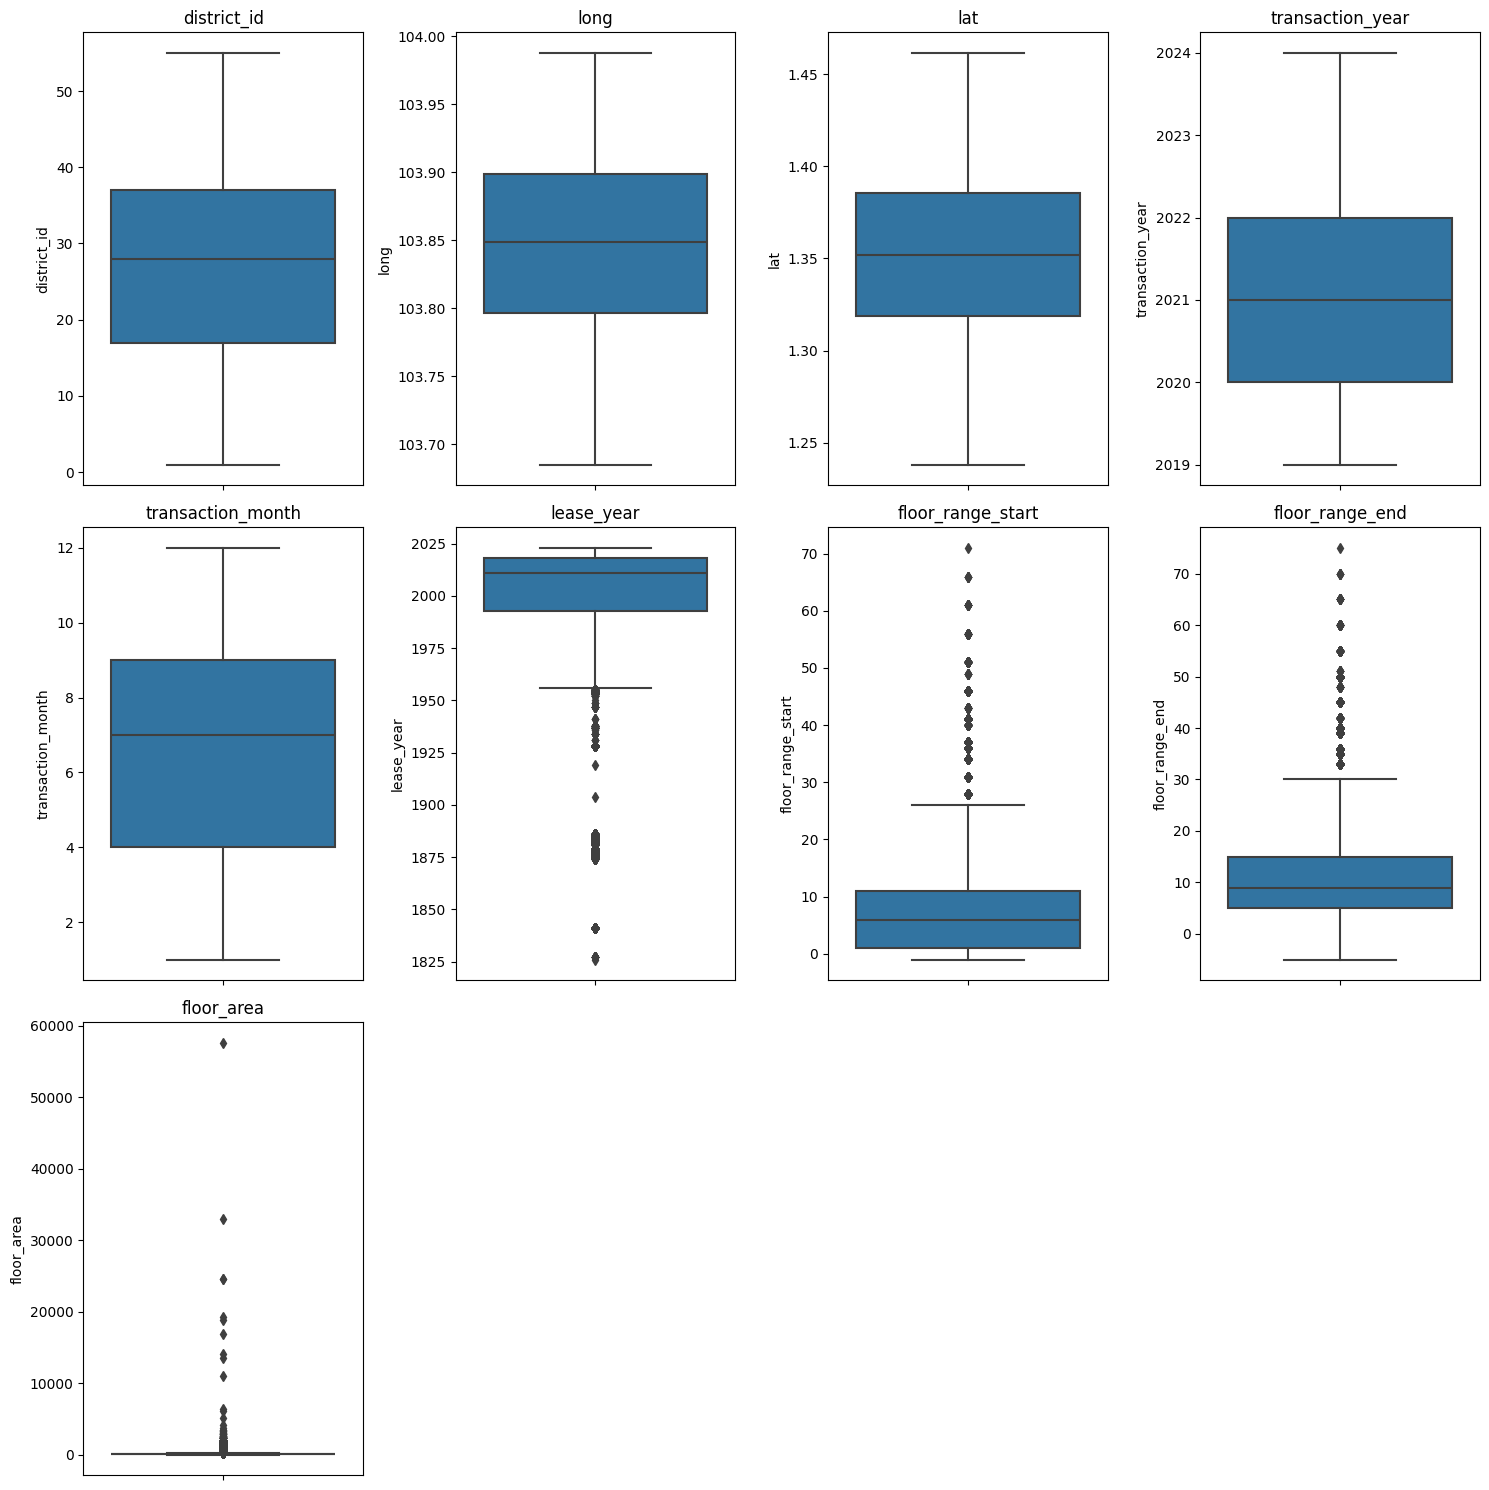

In [84]:
numeric_columns = data.dtypes[data.dtypes != 'object'].index
numeric_columns = list(numeric_columns)
numeric_columns.remove('price')
# Determine the number of rows and columns for subplots
num_rows = (len(numeric_columns) + 3) // 4
num_cols = 4
# Creating box plots for each numeric column based on 'Response'
plt.figure(figsize=(15, 5*num_rows))
for idx, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, num_cols, idx)
    sns.boxplot(data=data, y=column)
    plt.title(column)
plt.tight_layout()
plt.show()

Outliers in `lease_year` is valid as the zeroes represent freehold properties.
For the remaining columns `floor_range_start`, `floor_range_end`, the outliers can contain important information and should be preserved.
(For example, a large floor range indicate taller properties, which may signal higher prices)

Let's inspect outliers in `floor_area`

In [85]:
# Select the first quantile
q1 = data['floor_area'].quantile(.25)
# Select the third quantile
q3 = data['floor_area'].quantile(.75)
iqr = q3 - q1
# Create a mask inbeetween q1 & q3
outliers = data[(data['floor_area'] <= q1 - 3*iqr) | (data['floor_area'] >= q3 + 3*iqr)]

In [86]:
#inspect top outliers to conduct some research
outliers.nlargest(5, 'floor_area')

,district_id,long,lat,transaction_year,transaction_month,type_of_sale,price,property_type,lease_year,lease_duration,floor_range_start,floor_range_end,floor_area
66117,50,103.865323,1.352324,2022,7,Resale,890000000.0,Condominium,1980,99.0,21,25,57584.0
20646,53,103.844672,1.291553,2019,11,Resale,163333000.0,Apartment,1980,97.0,1,5,32931.0
95346,31,103.896307,1.311693,2021,11,Resale,815000000.0,Semi-detached,2018,freehold,1,5,24507.3
95348,31,103.896307,1.311693,2021,11,Resale,815000000.0,Semi-detached,2018,freehold,1,5,24507.3
31945,2,103.810942,1.329245,2021,10,Resale,550800000.0,Condominium,2018,freehold,1,5,19296.0


From research, extreme outliers with floor_area over 30000 are collective sales, comprising more than one property. Outliers also only make up about 3% of data. Drop outliers because regression model is very sensitive to outliers. In a later step, when we run correlation analysis, we see that dropping outliers decreases corr. coef of price and floor area from 0.88 to 0.51, suggesting that this is a good strategy.

In [87]:
#drop outliers, only keep data within 3 IQR
data = data[(data['floor_area'] >= q1 - 3*iqr) & (data['floor_area'] <= q3 + 3*iqr)]

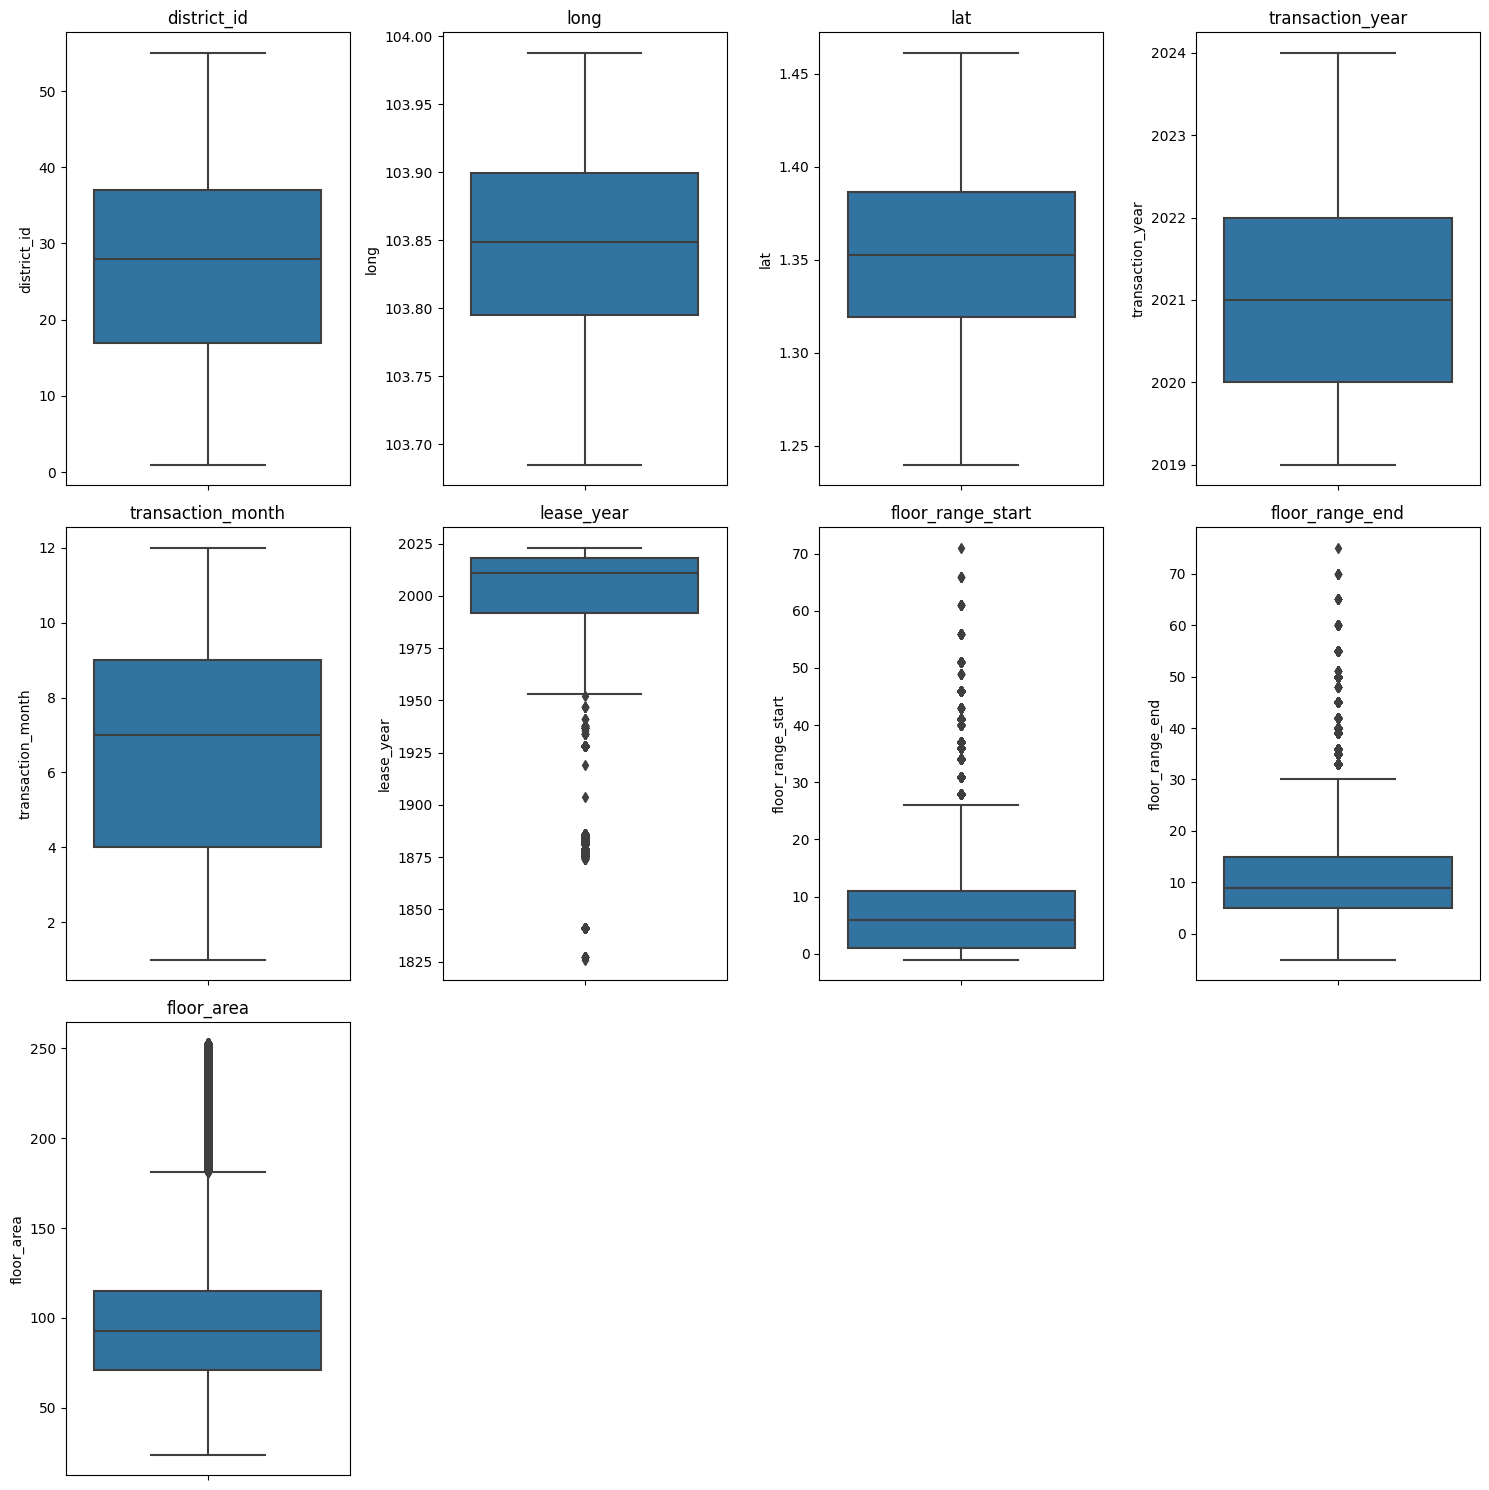

In [88]:
numeric_columns = data.dtypes[data.dtypes != 'object'].index
numeric_columns = list(numeric_columns)
numeric_columns.remove('price')
# Determine the number of rows and columns for subplots
num_rows = (len(numeric_columns) + 3) // 4
num_cols = 4
# Creating box plots for each numeric column based on 'Response'
plt.figure(figsize=(15, 5*num_rows))
for idx, column in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, num_cols, idx)
    sns.boxplot(data=data, y=column)
    plt.title(column)
plt.tight_layout()
plt.show()

# Exploratory Data Analysis (EDA)

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243703 entries, 2 to 251894
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   district_id        243703 non-null  int64  
 1   long               243703 non-null  float64
 2   lat                243703 non-null  float64
 3   transaction_year   243703 non-null  int64  
 4   transaction_month  243703 non-null  int64  
 5   type_of_sale       243703 non-null  object 
 6   price              243703 non-null  float64
 7   property_type      243703 non-null  object 
 8   lease_year         243703 non-null  int64  
 9   lease_duration     243703 non-null  object 
 10  floor_range_start  243703 non-null  int64  
 11  floor_range_end    243703 non-null  int64  
 12  floor_area         243703 non-null  float64
dtypes: float64(4), int64(6), object(3)
memory usage: 26.0+ MB


In [90]:
# Descriptive statistics for all numerical variables
numerical_variables = data.select_dtypes(include=['int64', 'float64'])
numerical_variables = numerical_variables.columns
descriptive_stats = data[numerical_variables].describe().loc[['mean', 'std', 'min','50%','max']].transpose()
descriptive_stats.columns = ['mean', 'std','min', 'median','max']
descriptive_stats['variance'] = descriptive_stats['std']**2
descriptive_stats['mode'] = data[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(data[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(data[x]) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(data[x]) for x in numerical_variables]

descriptive_stats

,mean,std,min,median,max,variance,mode,mad,kurtosis,skewness
district_id,2.773899e+01,16.806257,1.000000,28.000000,5.500000e+01,2.824503e+02,49.000000,11.000000,-1.090678,0.010134
long,1.038472e+02,0.066707,103.685228,103.848597,1.039878e+02,4.449851e-03,103.759618,0.051324,-0.818790,-0.244575
lat,1.355460e+00,0.044683,1.239927,1.352449,1.461129e+00,1.996555e-03,1.316402,0.033612,-0.646074,0.218190
transaction_year,2.021168e+03,1.397562,2019.000000,2021.000000,2.024000e+03,1.953179e+00,2021.000000,1.000000,-0.932059,0.051207
transaction_month,6.586841e+00,3.433182,1.000000,7.000000,1.200000e+01,1.178674e+01,7.000000,3.000000,-1.197415,-0.066460
price,1.055992e+06,891995.933132,100000.000000,740000.000000,1.250000e+07,7.956567e+11,500000.000000,342000.000000,11.981316,2.711657
lease_year,2.002751e+03,20.483355,1826.000000,2011.000000,2.023000e+03,4.195678e+02,2018.000000,8.000000,15.980150,-3.110540
floor_range_start,7.648818e+00,6.998408,-1.000000,6.000000,7.100000e+01,4.897771e+01,1.000000,5.000000,4.973947,1.779438
floor_range_end,1.058062e+01,7.049069,-5.000000,9.000000,7.500000e+01,4.968937e+01,5.000000,4.000000,5.303807,1.862718
floor_area,9.794336e+01,34.038856,24.000000,93.000000,2.530000e+02,1.158644e+03,93.000000,22.000000,2.291008,1.067445


In [91]:
# Calculate the correlation matrix for numeric columns
# Select only the columns with non-categorical data types (numeric columns)
numeric_columns = data.dtypes[data.dtypes != 'object'].index
correlation = data[list(numeric_columns)].corr()

# Apply a color gradient to visualize the correlation matrix
# Use the 'Greens' colormap to represent correlation values with colors
# Format the displayed values to two decimal places for clarity
correlation_styled = correlation.style.background_gradient(cmap='Greens').format("{:.2f}")
correlation_styled


,district_id,long,lat,transaction_year,transaction_month,price,lease_year,floor_range_start,floor_range_end,floor_area
district_id,1.00,-0.09,0.20,-0.02,0.03,-0.09,-0.02,0.04,0.03,-0.05
long,-0.09,1.00,0.03,-0.00,0.00,0.02,0.07,-0.10,-0.09,0.01
lat,0.20,0.03,1.00,0.04,0.01,-0.37,0.01,-0.18,-0.22,0.06
transaction_year,-0.02,-0.00,0.04,1.00,-0.20,0.07,0.01,0.00,-0.00,0.01
transaction_month,0.03,0.00,0.01,-0.20,1.00,0.01,0.00,0.00,0.00,0.01
price,-0.09,0.02,-0.37,0.07,0.01,1.00,0.21,0.07,0.16,0.51
lease_year,-0.02,0.07,0.01,0.01,0.00,0.21,1.00,0.13,0.17,-0.09
floor_range_start,0.04,-0.10,-0.18,0.00,0.00,0.07,0.13,1.00,0.99,-0.09
floor_range_end,0.03,-0.09,-0.22,-0.00,0.00,0.16,0.17,0.99,1.00,-0.08
floor_area,-0.05,0.01,0.06,0.01,0.01,0.51,-0.09,-0.09,-0.08,1.00


We see that `floor_range_start` and `floor_range_end` has high correlation of 0.99, which can be explained by the fact that there is a sizeable number of properties which are private properties with relatively lower number of floors (1-3). it is reasonable to assume that if you know the floor_start is 1, floor_end is likely to be 2 or 3 for these properties. However, floor_range information may be important for properties with large number of floors, thus it should not be dropped.

Next, we also see that floor_area and price has a high correlation of 0.51 we can examine their relationship further.

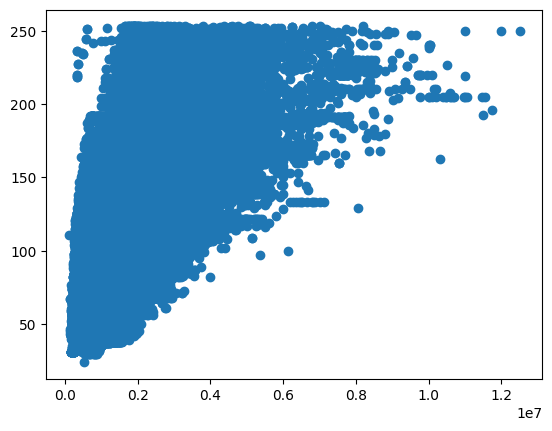

In [92]:
plt.scatter(data.price, data.floor_area)

# Feature Engineering

## Add distance to nearest amenity and no. of amenities within 5km

In [93]:
from math import cos, asin, sqrt, pi
##this function takes in four values (two pairs of lat long values) and calculates the distance between the two points in km
def distance_between_coords(lat1, long1, lat2, long2):
    r = 6371 # km
    p = pi / 180

    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((long2-long1)*p))/2
    return 2 * r * asin(sqrt(a))

In [94]:
#this function takes in a lat, long value and a subset group of amenity (eg. mrt stations)
#returns value of distance to nearest instance of the amenity (in km) amd count of amenities within specified radius
def distance_to_nearest_amenity_type(lat1, long1, amenity_subset, radius):
    amenity_subset['distance'] = amenity_subset.apply(lambda x: distance_between_coords(x['lat'],x['long'], lat1, long1), axis=1)
    count_n = len(amenity_subset[amenity_subset['distance'] <= radius])
    min_dist = min(amenity_subset['distance'])
    return (min_dist, count_n)

In [95]:
# derive values of distance to nearest amenity X, for (Carpark, Park, Supermarket, Kindergarten, Pharmacy, Gym, Mrt Station, Hawker)
carparks = amenities[amenities['amenity_type'] == 'Carpark']
data[['dist_to_nearest_carpark', 'n_carparks']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], carparks, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_carparks': int})


In [96]:
parks = amenities[amenities['amenity_type'] == 'Park']
data[['dist_to_nearest_park', 'n_parks']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], parks, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_parks': int})

In [97]:
supermarkets = amenities[amenities['amenity_type'] == 'Supermarket']
data[['dist_to_nearest_supermarket', 'n_supermarkets']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], supermarkets, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_supermarkets': int})

In [98]:
kindergartens = amenities[amenities['amenity_type'] == 'Kindergarten']
data[['dist_to_nearest_kindergarten', 'n_kindergartens']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], kindergartens, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_kindergartens': int})

In [99]:
pharmacies= amenities[amenities['amenity_type'] == 'Pharmacy']
data[['dist_to_nearest_pharmacy', 'n_pharmacies']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], pharmacies, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_pharmacies': int})

In [100]:
gyms = amenities[amenities['amenity_type'] == 'Gym']
data[['dist_to_nearest_gym', 'n_gyms']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], gyms, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_gyms': int})

In [101]:
mrt_stations = amenities[amenities['amenity_type'] == 'MRT']
data[['dist_to_nearest_mrt_station', 'n_mrt_stations']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], mrt_stations, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_mrt_stations': int})

In [102]:
lrt_stations = amenities[amenities['amenity_type'] == 'LRT']
data[['dist_to_nearest_lrt_station', 'n_lrt_stations']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], lrt_stations, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_lrt_stations': int})

In [103]:
hawkers = amenities[amenities['amenity_type'] == 'Hawker']
data[['dist_to_nearest_hawker', 'n_hawkers']] = data.apply(lambda x: distance_to_nearest_amenity_type(x['lat'], x['long'], hawkers, 5), axis=1, result_type='expand')
#force number of nearby amenities to int
data = data.astype({'n_hawkers': int})

## Group Districts into Regions

There are over 50 regions, and trying to encode all as dummy variables will very quickly inflate the number of regressors. Besides from preliminary testing, when used as individual features, many of the districts have regression coefficients 'squashed' to zero when using lasso regression, possibly signifying that they are less significant (see Appendix X).

Therefore, group districts into 4 regions as defined by URA's planning area definitions.

In [104]:
districts_to_region_mapping = {
    'EAST': ['BEDOK', 'PAYA LEBAR', 'CHANGI', 'CHANGI BAY', 'PASIR RIS', 'TAMPINES'],
    'CENTRAL': ['MUSEUM', 'GEYLANG', 'STRAITS VIEW', 'KALLANG', 'MARINA EAST', 'MARINA SOUTH', 'NOVENA',
                'BISHAN', 'OUTRAM', 'RIVER VALLEY', 'ROCHOR', 'TOA PAYOH', 'SINGAPORE RIVER', 'BUKIT TIMAH',
                'NEWTON', 'BUKIT MERAH', 'DOWNTOWN CORE', 'MARINE PARADE', 'SOUTHERN ISLANDS', 'ORCHARD', 'QUEENSTOWN',
                'TANGLIN'],
    'NORTH-EAST': ['HOUGANG', 'SELETAR', 'SENGKANG', 'SERANGOON', 'ANG MO KIO', 'NORTH-EASTERN ISLANDS', 'PUNGGOL'],
    'NORTH':['MANDAI', 'SUNGEI KADUT', 'BUKIT PANJANG', 'CENTRAL WATER CATCHMENT', 'LIM CHU KANG', 'WOODLANDS', 'SEMBAWANG', 'SIMPANG', 'YISHUN'],
    'WEST':['JURONG EAST', 'JURONG WEST', 'CHOA CHU KANG', 'TENGAH', 'CLEMENTI', 'BUKIT BATOK', 'BOON LAY',
            'WESTERN WATER CATCHMENT', 'PIONEER', 'WESTERN ISLANDS'],
}

In [105]:
def region_from_district(district_in_string, mapping):
    for key in mapping.keys():
        if district_in_string in mapping[key]:
            return key
    return "NA"

In [106]:
#obtain dict mapping of district id to name
districts_id_to_name = dict(zip(districts['id'], districts['district_name']))
data['district_name'] = data['district_id'].map(districts_id_to_name)
data['region'] = data['district_name'].apply(lambda x: region_from_district(x, districts_to_region_mapping))
data = data.drop('district_id', axis=1)
data = data.drop('district_name', axis=1)

# Preprocessing Features

## Inspect dataframe information to address categorical variables

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243703 entries, 2 to 251894
Data columns (total 31 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   long                          243703 non-null  float64
 1   lat                           243703 non-null  float64
 2   transaction_year              243703 non-null  int64  
 3   transaction_month             243703 non-null  int64  
 4   type_of_sale                  243703 non-null  object 
 5   price                         243703 non-null  float64
 6   property_type                 243703 non-null  object 
 7   lease_year                    243703 non-null  int64  
 8   lease_duration                243703 non-null  object 
 9   floor_range_start             243703 non-null  int64  
 10  floor_range_end               243703 non-null  int64  
 11  floor_area                    243703 non-null  float64
 12  dist_to_nearest_carpark       243703 non-null  fl

## Encode categorical variables

In [108]:
# Select categorical features from the dataset
categoricals = data.select_dtypes(exclude=[np.number])

# Display unique identifiers for each categorical feature
for c in categoricals.columns:
    print('{:<15}'.format(c), data[c].unique())


type_of_sale    ['Resale' 'Sub sale' 'New sale' 'HDB Resale']
property_type   ['Terrace' 'Strata Terrace' 'Condominium' 'Apartment' 'Semi-detached'
 'Executive Condominium' 'Detached' 'Strata Semi-detached'
 'Strata Detached' '2 ROOM' '3 ROOM' '4 ROOM' 'EXECUTIVE' '5 ROOM'
 '1 ROOM' 'MULTI-GENERATION']
lease_duration  ['freehold' 99.0 956.0 999.0 85.0 93.0 102.0 929.0 999999.0 9999.0 110.0
 103.0 947.0 993.0 946.0 60.0 70.0 101.0 863.0 945.0 940.0 100.0 998.0]
region          ['CENTRAL' 'WEST' 'NORTH-EAST' 'EAST' 'NORTH']


## Manually assign values for ordinal variables

In [109]:
# lease_duration is ordinal variables, can map to numerical values
data['lease_duration'] = data['lease_duration'].map({'freehold': 23,  99.0:5, 956.0:17, 999.0:18, 85.0:3,  93.0:4, 102.0:8, 929.0:12, 999999.0:22, 9999.0:21, 110.0:10, 103.0:9, 947.0:16, 993.0:19, 946.0:15, 60.0:1, 70.0:2,  101.0:7, 863.0:11, 945.0:14, 940.0:12, 100.0: 6, 998.0:20})

## Automatically encode nominal dummy variables

In [110]:
# Create dummy variables for specific columns, while dropping the first column to prevent multicollinearity
dummy_col = pd.get_dummies(data[['type_of_sale', 'property_type', 'region']], drop_first=True)

# Extract the list of column names for the new categorical columns
categorical_col = list(dummy_col.columns)

# Concatenate the dummy variables with the original DataFrame
data= pd.concat([data, dummy_col], axis=1)

# Drop the original categorical columns
data = data.drop(['type_of_sale', 'property_type', 'region'], axis=1)

In [111]:
#verify all variables are of suitable format
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 243703 entries, 2 to 251894
Data columns (total 50 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   long                                 243703 non-null  float64
 1   lat                                  243703 non-null  float64
 2   transaction_year                     243703 non-null  int64  
 3   transaction_month                    243703 non-null  int64  
 4   price                                243703 non-null  float64
 5   lease_year                           243703 non-null  int64  
 6   lease_duration                       243703 non-null  int64  
 7   floor_range_start                    243703 non-null  int64  
 8   floor_range_end                      243703 non-null  int64  
 9   floor_area                           243703 non-null  float64
 10  dist_to_nearest_carpark              243703 non-null  float64
 11  n_carparks        

# Linear Regression

## Standardisation

In [112]:
from sklearn.preprocessing import StandardScaler

num_col = data.select_dtypes(include=['int', 'float']).columns

scaler = StandardScaler()

# Apply standardization to the numeric columns
data[num_col] = scaler.fit_transform(data[num_col])

## Splitting Dataset

In [49]:
from sklearn.model_selection import train_test_split

# Extract the price column as the target variable and remove it from the data
y = data.pop('price')

# 'X' now contains the remaining features
X = data

#split train, test set into 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3107)

In [50]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

#fit training set
fitted_model = lr.fit(X_train, y_train)

#predict and get accuracy of training set(aka. r-squared of linear regression model)
fitted_model.predict(X_train)
r2_train = fitted_model.score()
print("R-squared score on training set:", r2_train)

#predict and get accuracy of test set (aka. r-squared of linear regression model)
fitted_model.predict(X_test)
r2_test = fitted_model.score()
print("R-squared score on test set:", r2_train)

R-squared score on training set: 0.8515909055969932


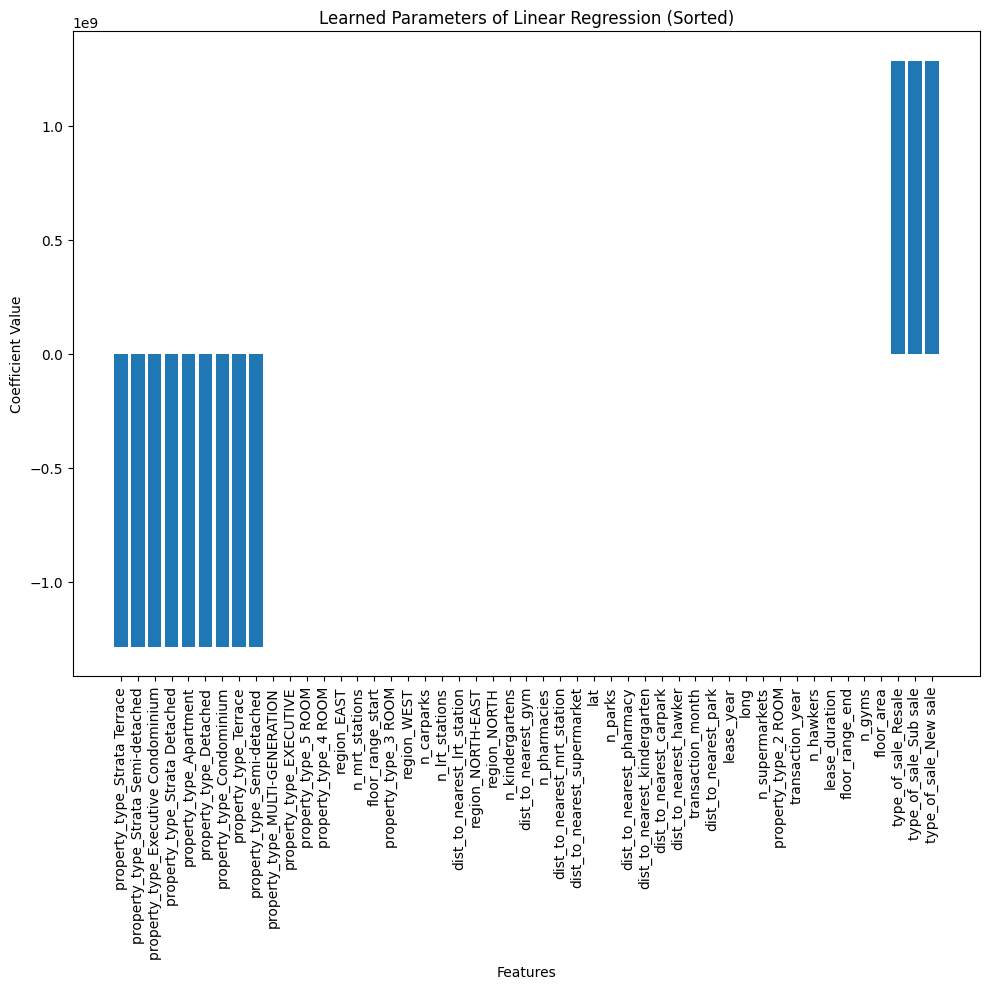

In [51]:
import matplotlib.pyplot as plt

# Get the coefficients from the fitted model
coefficients = model.params[1:]  # Exclude the intercept

# Get the feature names
feature_names = X.columns

# Create a DataFrame to store coefficients and feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients in descending order
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=True)

# Create a vertical bar plot of sorted coefficients
plt.figure(figsize=(10, 10))
plt.bar(coefficients_df['Feature'], coefficients_df['Coefficient'])
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.title("Learned Parameters of Linear Regression (Sorted)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()  # Ensures all labels are visible
plt.show()

In [52]:
print("P-values for coefficients:")
print(model.pvalues)

P-values for coefficients:
const                                   4.033576e-03
long                                   7.727829e-130
lat                                     3.837987e-15
transaction_year                        0.000000e+00
transaction_month                      2.334517e-215
lease_year                              0.000000e+00
lease_duration                          0.000000e+00
floor_range_start                       4.130712e-02
floor_range_end                         4.843130e-03
floor_area                              0.000000e+00
dist_to_nearest_carpark                 1.086176e-34
n_carparks                              3.077259e-63
dist_to_nearest_park                    0.000000e+00
n_parks                                 2.359095e-24
dist_to_nearest_supermarket            5.143879e-113
n_supermarkets                         3.276487e-108
dist_to_nearest_kindergarten            4.727564e-33
n_kindergartens                         5.140587e-23
dist_to_nearest_pha

## Lasso Regression

In [53]:
from sklearn.linear_model import Lasso


lm = Lasso(alpha=0.01)
lm.fit(X,y)

Lasso(alpha=0.01)

In [54]:
y_pred = lm.predict(X)

In [55]:
from sklearn.metrics import r2_score
print(r2_score(y_true=y,y_pred=y_pred))

0.8248763590556569


In [56]:
# Get the coefficients and intercept from the linear regression model
model_parameter = list(lm.coef_)  # Coefficients of features
model_parameter.insert(0, lm.intercept_)  # Intercept

# Round the coefficients and intercept to three decimal places
model_parameter = [round(x, 3) for x in model_parameter]

# Get the list of column names from the feature matrix
col = list(X.columns)

# Insert 'Constant' as the first element in the list of column names
col.insert(0, 'Constant')

# Combine the column names and corresponding model parameters using zip
parameter_summary = list(zip(col, model_parameter))
parameter_summary

[('Constant', -0.098),
 ('long', -0.0),
 ('lat', -0.005),
 ('transaction_year', 0.104),
 ('transaction_month', 0.015),
 ('lease_year', 0.08),
 ('lease_duration', 0.192),
 ('floor_range_start', 0.0),
 ('floor_range_end', 0.081),
 ('floor_area', 0.592),
 ('dist_to_nearest_carpark', 0.0),
 ('n_carparks', -0.0),
 ('dist_to_nearest_park', 0.026),
 ('n_parks', 0.011),
 ('dist_to_nearest_supermarket', -0.0),
 ('n_supermarkets', -0.0),
 ('dist_to_nearest_kindergarten', 0.041),
 ('n_kindergartens', -0.008),
 ('dist_to_nearest_pharmacy', -0.0),
 ('n_pharmacies', 0.0),
 ('dist_to_nearest_gym', -0.014),
 ('n_gyms', 0.155),
 ('dist_to_nearest_mrt_station', -0.005),
 ('n_mrt_stations', -0.0),
 ('dist_to_nearest_lrt_station', 0.0),
 ('n_lrt_stations', 0.0),
 ('dist_to_nearest_hawker', -0.0),
 ('n_hawkers', 0.053),
 ('type_of_sale_New sale', 0.723),
 ('type_of_sale_Resale', 0.207),
 ('type_of_sale_Sub sale', 0.0),
 ('property_type_2 ROOM', 0.0),
 ('property_type_3 ROOM', -0.0),
 ('property_type_4 ROOM

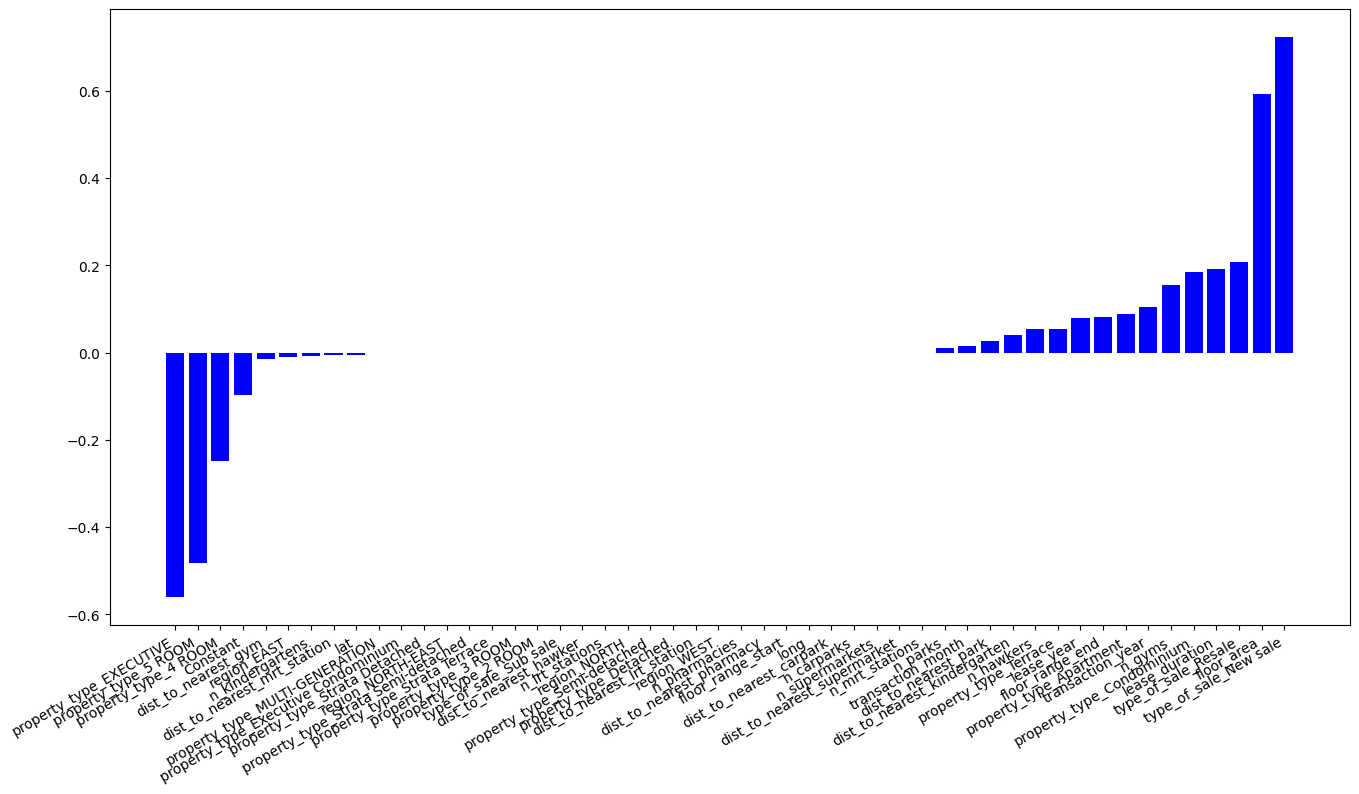

In [57]:
# Get the indices that would sort the model_parameter array
index = np.argsort(model_parameter)

# Sort the column names and model parameters based on the sorted indices
col, model_parameter = np.array(col)[index], np.array(model_parameter)[index]

# Create a figure for the bar plot
plt.figure(figsize=(16, 8))

# Create a bar plot to visualize the learned parameters
plt.bar(np.arange(len(col)), model_parameter, color='blue')

# Set x-axis ticks and labels
plt.xticks(np.arange(len(col)), col, rotation=30, ha='right')

# Display the plot
plt.show()

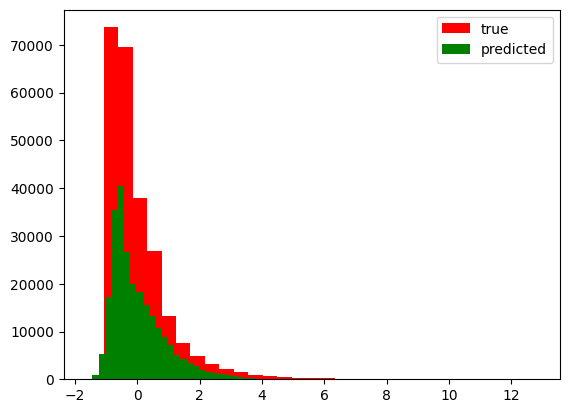

In [58]:
# Create a new figure for the histograms
plt.figure()

# Create histograms for true and predicted values
# Use red color for true values and green color for predicted values
# Set the number of bins to 30 for each histogram
plt.hist(y, label='true', color='red', bins=30)
plt.hist(y_pred, label='predicted', color='green', bins=30)

# Add a legend to distinguish between true and predicted histograms
plt.legend()

In [59]:
from sklearn.linear_model import Ridge

lm = Ridge(alpha=10)
lm.fit(X,y)

Ridge(alpha=10)

In [60]:
y_pred = lm.predict(X)

In [61]:
from sklearn.metrics import r2_score
print(r2_score(y_true=y,y_pred=y_pred))

0.8515788515813973


In [62]:
# Get the coefficients and intercept from the linear regression model
model_parameter = list(lm.coef_)  # Coefficients of features
model_parameter.insert(0, lm.intercept_)  # Intercept

# Round the coefficients and intercept to three decimal places
model_parameter = [round(x, 3) for x in model_parameter]

# Get the list of column names from the feature matrix
col = list(X.columns)

# Insert 'Constant' as the first element in the list of column names
col.insert(0, 'Constant')

# Combine the column names and corresponding model parameters using zip
parameter_summary = list(zip(col, model_parameter))
parameter_summary

[('Constant', -0.038),
 ('long', 0.07),
 ('lat', -0.02),
 ('transaction_year', 0.118),
 ('transaction_month', 0.025),
 ('lease_year', 0.069),
 ('lease_duration', 0.16),
 ('floor_range_start', -0.175),
 ('floor_range_end', 0.255),
 ('floor_area', 0.625),
 ('dist_to_nearest_carpark', 0.012),
 ('n_carparks', -0.081),
 ('dist_to_nearest_park', 0.038),
 ('n_parks', -0.016),
 ('dist_to_nearest_supermarket', -0.021),
 ('n_supermarkets', 0.077),
 ('dist_to_nearest_kindergarten', 0.011),
 ('n_kindergartens', -0.03),
 ('dist_to_nearest_pharmacy', -0.004),
 ('n_pharmacies', -0.023),
 ('dist_to_nearest_gym', -0.029),
 ('n_gyms', 0.333),
 ('dist_to_nearest_mrt_station', -0.022),
 ('n_mrt_stations', -0.239),
 ('dist_to_nearest_lrt_station', -0.073),
 ('n_lrt_stations', -0.079),
 ('dist_to_nearest_hawker', 0.016),
 ('n_hawkers', 0.121),
 ('type_of_sale_New sale', 0.691),
 ('type_of_sale_Resale', 0.09),
 ('type_of_sale_Sub sale', 0.562),
 ('property_type_2 ROOM', 0.314),
 ('property_type_3 ROOM', 0.03

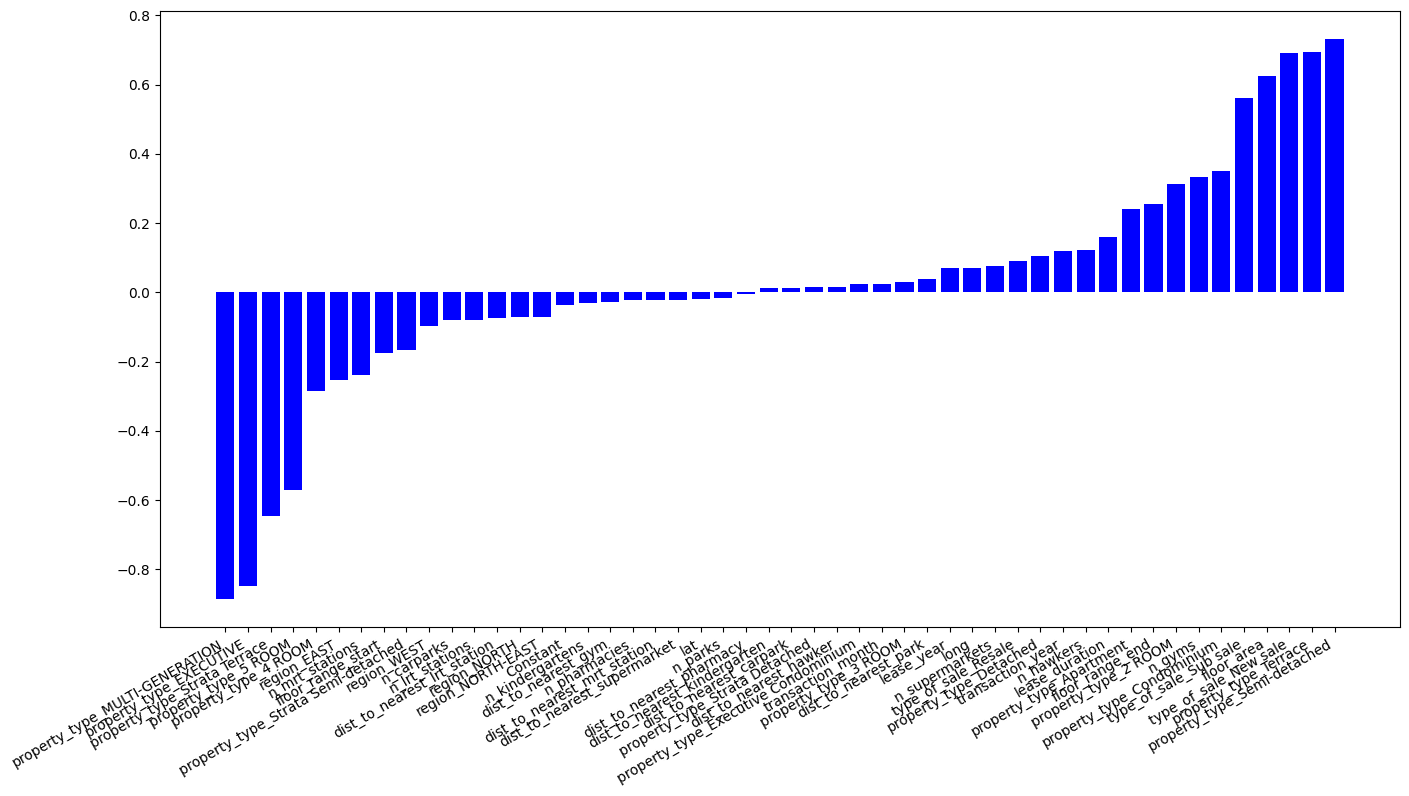

In [63]:
# Get the indices that would sort the model_parameter array
index = np.argsort(model_parameter)

# Sort the column names and model parameters based on the sorted indices
col, model_parameter = np.array(col)[index], np.array(model_parameter)[index]

# Create a figure for the bar plot
plt.figure(figsize=(16, 8))

# Create a bar plot to visualize the learned parameters
plt.bar(np.arange(len(col)), model_parameter, color='blue')

# Set x-axis ticks and labels
plt.xticks(np.arange(len(col)), col, rotation=30, ha='right')

# Display the plot
plt.show()

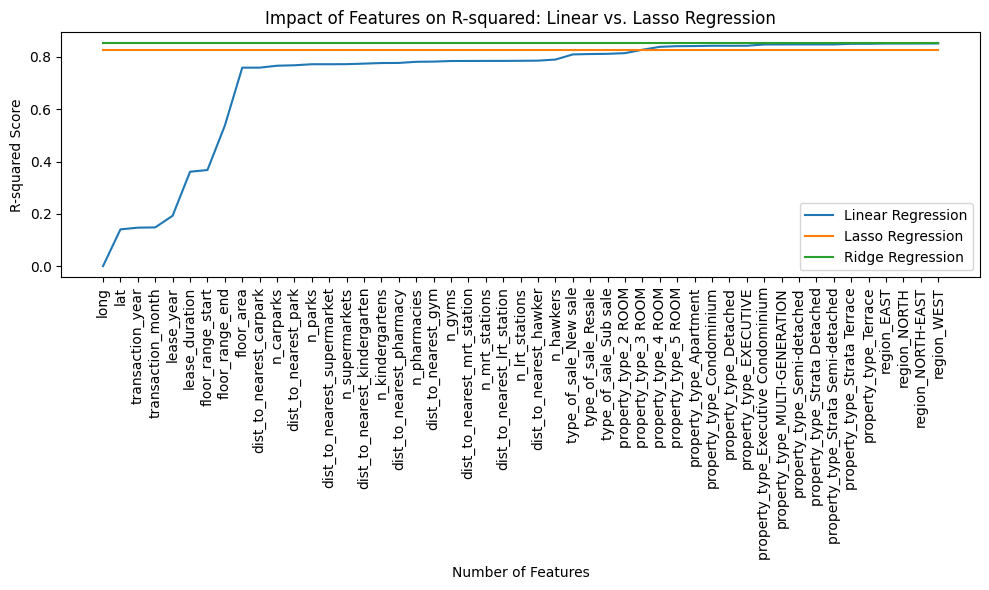

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

# Initialize lists to store R-squared scores for Linear, Lasso and Ridge regression
linear_r2_scores = []
lasso_r2_scores = []
ridge_r2_scores = []

# Iterate through each feature and add it iteratively to Linear regression
for i in range(1, len(X.columns) + 1):
    # Select the current subset of features for Linear regression
    X_subset = X.iloc[:, :i]
    
    # Fit Linear regression
    linear_model = LinearRegression()
    linear_model.fit(X_subset, y)
    y_pred_linear = linear_model.predict(X_subset)
    
    # Calculate and store R-squared score for Linear regression
    linear_r2_scores.append(r2_score(y, y_pred_linear))
    
# Fit Lasso regression with all features
lasso_model = Lasso(alpha=0.01)  # Adjust alpha as needed
lasso_model.fit(X, y)
y_pred_lasso = lasso_model.predict(X)

# Calculate the R-squared score for Lasso regression
lasso_r2 = r2_score(y, y_pred_lasso)
lasso_r2_scores = [lasso_r2] * len(X.columns)

# Fit Ridge regression with all features
ridge_model = Ridge(alpha=1)  # Adjust alpha as needed
ridge_model.fit(X, y)
y_pred_ridge = ridge_model.predict(X)

# Calculate the R-squared score for Ridge regression
ridge_r2 = r2_score(y, y_pred_ridge)
ridge_r2_scores = [ridge_r2] * len(X.columns)

# Plot the R-squared scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(X.columns) + 1), linear_r2_scores, label='Linear Regression')
plt.plot(range(1, len(X.columns) + 1), lasso_r2_scores, label='Lasso Regression')
plt.plot(range(1, len(X.columns) + 1), ridge_r2_scores, label='Ridge Regression')
plt.xlabel("Number of Features")
plt.ylabel("R-squared Score")
plt.title("Impact of Features on R-squared: Linear vs. Lasso Regression")
plt.legend()
plt.xticks(range(1, len(X.columns) + 1), X.columns, rotation=90)
plt.tight_layout()
plt.show()